In this notebook, we will look into the data from a baseline and try some machine learning models.

# Imports

In [1]:
# Use this cell to regroup all your imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from scipy import stats
from tempfile import mkdtemp
from shutil import rmtree

from xgboost import XGBRegressor

from sklearn import set_config
set_config(display = 'diagram')

# Sklearn preprocessing
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.ensemble import AdaBoostRegressor, VotingRegressor, GradientBoostingRegressor, StackingRegressor, RandomForestRegressor
from sklearn.feature_selection import SelectPercentile, mutual_info_regression, VarianceThreshold, SelectFromModel
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.metrics import make_scorer, mean_squared_error, mean_squared_log_error
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, OrdinalEncoder
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor

# Load the data

In [2]:
data = pd.read_csv('https://wagon-public-datasets.s3.amazonaws.com/houses_train_raw.csv', index_col='Id')
data

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500


In [3]:
X = data.drop(columns=['SalePrice'])
y = data.SalePrice

X.shape, y.shape

((1460, 79), (1460,))

## Categoraical features

In [4]:
feat_categorical_nunique = X.select_dtypes(include='object').nunique()
print(f'There are {feat_categorical_nunique.sum()} different categorial values in our data')

There are 252 different categorial values in our data


<AxesSubplot:>

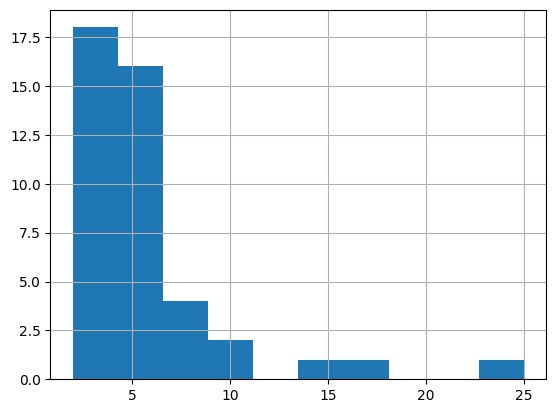

In [5]:
# Let's see how many diffrent values there is per columns
feat_categorical_nunique.hist()

In [6]:
# Let's keep coloumns with less than 7 unique values
# categorical features to one-hot-encode
feat_categorical_small = list(feat_categorical_nunique[feat_categorical_nunique < 7].index)

feat_categorical_small

['MSZoning',
 'Street',
 'Alley',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'BldgType',
 'RoofStyle',
 'MasVnrType',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 'KitchenQual',
 'FireplaceQu',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'PoolQC',
 'Fence',
 'MiscFeature',
 'SaleCondition']

In [7]:
len(feat_categorical_small)

34

# Baseline Pipe

## Preprocessing

In [8]:
preproc_numerical_baseline = make_pipeline(
    SimpleImputer(),
    MinMaxScaler()
)

preproc_categorical_baseline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore")
)

preproc_baseline = make_column_transformer(
    (preproc_numerical_baseline, make_column_selector(dtype_include=["int64", "float64"])),
    (preproc_categorical_baseline, feat_categorical_small),
    remainder="drop"
)

preproc_baseline

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('minmaxscaler',
                                                  MinMaxScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f4ad46fe320>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ign...
                                 ['MSZoning', 'Street', 'Alley', 'LotShape',
                                  'LandContour', 'Utilities', 'LotConfig',
                                  'LandSlope', 'BldgType', 'RoofStyle',
                                  'MasVnrType', 'ExterQual', 'ExterCond',
                                  'Foundation', 'BsmtQual', 'BsmtCond',
                                  'BsmtExposure', 'BsmtFinType1',
                                  'BsmtFinType2', 'Heating', 'HeatingQC',
                                  'CentralAir', 'Electrical', 'KitchenQual',
                                  'FireplaceQu', 'GarageType', 'GarageFinish',
                                  'GarageQual', 'GarageCond', 'PavedDrive', ...])])

In [9]:
shape_preproc_baseline = preproc_baseline.fit_transform(X).shape
shape_preproc_baseline

(1460, 183)

## Add Estimator

In [10]:
pipe_baseline = make_pipeline(preproc_baseline, DecisionTreeRegressor())
pipe_baseline

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f4ad46fe320>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencod...
                                                   'LotConfig', 'LandSlope',
                                                   'BldgType', 'RoofStyle',
                                                   'MasVnrType', 'ExterQual',
                                                   'ExterCond', 'Foundation',
                                                   'BsmtQual', 'BsmtCond',
                                                   'BsmtExposure',
                                                   'BsmtFinType1',
                                                   'BsmtFinType2', 'Heating',
                                                   'HeatingQC', 'CentralAir',
                                                   'Electrical', 'KitchenQual',
                                                   'FireplaceQu', 'GarageType',
                                                   'GarageFinish', 'GarageQual',
                                                   'GarageCond', 'PavedDrive', ...])])),
                ('decisiontreeregressor', DecisionTreeRegressor())])

## Cross validate

The Kaggle Competition use Root Mean Squared Logarithmic Error (RMSLE). 
We will need to create our custom `sklearn.metrics.scorer` object to pass to any cross-validation or Grid Search.

In [11]:
# OPTION 1: recode it all manually
def root_mean_squared_log_error(y_true, y_pred):
    t = np.array(y_true)
    p = np.array(y_pred)

    log_error = np.log(1+t) - np.log(1+p)

    return ((log_error**2).mean())**0.5

# This is our metric to minimize
rmsle = make_scorer(root_mean_squared_log_error)

# This is our score to maximize
rmsle_neg = make_scorer(lambda y_true, y_pred: -1 * root_mean_squared_log_error(y_true, y_pred))

In [12]:
# OPTION 2 - re-use Sklearn's "mean_squared_log_error"

# This is our metric to minimize
rmsle = make_scorer(lambda y_true, y_pred: mean_squared_log_error(y_true, y_pred)**0.5)

# This is our score to maximize
rmsle_neg = make_scorer(lambda y_true, y_pred: -1 * mean_squared_log_error(y_true, y_pred)**0.5)

# Equivalent formulation
rmsle_neg = make_scorer(
    lambda y_true, y_pred: mean_squared_log_error(y_true, y_pred)**0.5,
    greater_is_better=False
)

In [21]:
# 5-fold cross-validate the pipe_baseline to get a first flance of our baseline performance

score_baseline = cross_val_score(pipe_baseline, X, y, cv=5, scoring=rmsle).mean()
print( f'We get a RMSLE prediction score of {round(score_baseline,2)}, a resonable starting point.')

We get a RMSLE prediction score of 0.21, a resonable starting point.


## Predict Baseline

In [14]:
X_test = pd.read_csv("https://wagon-public-datasets.s3.amazonaws.com/houses_test_raw.csv")
X_test_ids = X_test['Id'] # Keep ids
X_test = X_test.drop(columns=['Id'])

# Predict y_pred_baseline
pipe_baseline.fit(X,y)
y_pred_baseline = pipe_baseline.predict(X_test)
y_pred_baseline

array([127500., 157000., 173000., ..., 139000., 108000., 192000.])

In [15]:
results = pd.concat([X_test_ids, pd.Series(y_pred_baseline, name="SalePrice")], axis=1)
results.head(1)

,Id,SalePrice
0,1461,127500.0


# Export CSV for submission

In [17]:
# Save result into a CSV file 
import os

# Specify the folder path
folder_path = "data"  # Replace with the actual folder path you want

# Create the folder if it doesn't exist
if not os.path.exists(folder_path):
    os.makedirs(folder_path)

# Save the DataFrame to a CSV file in the specified folder
file_path = os.path.join(folder_path, "submission_baseline.csv")
results.to_csv(file_path, header=True, index=False)

# Iteration

## Ordinal Encoder

### Approach explained

In [22]:
# Define specific order for features
# Note: if you change this order, it will change the output for .transform()
feature_A_sorted_values = ['bad', 'average', 'good'] 
feature_B_sorted_values = ['dirty', 'clean', 'new']

encoder = OrdinalEncoder(
    categories=[
        feature_A_sorted_values,
        feature_B_sorted_values
    ],
    handle_unknown="use_encoded_value",
    unknown_value=-1
)

# Just some random training data
XX = [
    ['good', 'dirty'],
    ['bad', 'new'],
    ['average', 'clean'],
]

encoder.fit(XX)

encoder.transform([
        ['bad', "dirty"],
        ["average", "clean"],
        ['good', 'new'],
        ['bad', 'oops never seen this label before']
])

array([[ 0.,  0.],
       [ 1.,  1.],
       [ 2.,  2.],
       [ 0., -1.]])

### Features to encode

In [24]:
feat_ordinal_dict = {
    # Considers "missing" as "neutral"
    "BsmtCond": ['missing', 'Po', 'Fa', 'TA', 'Gd'],
    "BsmtExposure": ['missing', 'No', 'Mn', 'Av', 'Gd'],
    "BsmtFinType1": ['missing', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],
    "BsmtFinType2": ['missing', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],
    "BsmtQual": ['missing', 'Fa', 'TA', 'Gd', 'Ex'],
    "Electrical": ['missing', 'Mix', 'FuseP', 'FuseF', 'FuseA', 'SBrkr'],
    "ExterCond": ['missing', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    "ExterQual": ['missing', 'Fa', 'TA', 'Gd', 'Ex'],
    "Fence": ['missing', 'MnWw', 'GdWo', 'MnPrv', 'GdPrv'],
    "FireplaceQu": ['missing', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    "Functional": ['missing', 'Sev', 'Maj2', 'Maj1', 'Mod', 'Min2', 'Min1', 'Typ'],
    "GarageCond": ['missing', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    "GarageFinish": ['missing', 'Unf', 'RFn', 'Fin'],
    "GarageQual": ['missing', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    "HeatingQC": ['missing', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    "KitchenQual": ['missing', 'Fa', 'TA', 'Gd', 'Ex'],
    "LandContour": ['missing', 'Low', 'Bnk', 'HLS', 'Lvl'],
    "LandSlope": ['missing', 'Sev', 'Mod', 'Gtl'],
    "LotShape": ['missing', 'IR3', 'IR2', 'IR1', 'Reg'],
    "PavedDrive": ['missing', 'N', 'P', 'Y'],
    "PoolQC": ['missing', 'Fa', 'Gd', 'Ex']
}

feat_ordinal = sorted(feat_ordinal_dict.keys()) # sort alphabetically
feat_ordinal_values_sorted = [feat_ordinal_dict[i] for i in feat_ordinal]

encoder_ordinal = OrdinalEncoder(
    categories=feat_ordinal_values_sorted,
    dtype= np.int64,
    handle_unknown="use_encoded_value",
    unknown_value=-1 # Considers unknown values as worse than "missing"
)

preproc_ordinal = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="missing"),
    encoder_ordinal,
    MinMaxScaler()
)

preproc_ordinal

Pipeline(steps=[('simpleimputer',
                 SimpleImputer(fill_value='missing', strategy='constant')),
                ('ordinalencoder',
                 OrdinalEncoder(categories=[['missing', 'Po', 'Fa', 'TA', 'Gd'],
                                            ['missing', 'No', 'Mn', 'Av', 'Gd'],
                                            ['missing', 'Unf', 'LwQ', 'Rec',
                                             'BLQ', 'ALQ', 'GLQ'],
                                            ['missing', 'Unf', 'LwQ', 'Rec',
                                             'BLQ', 'ALQ', 'GLQ'],
                                            ['missing', 'Fa', 'TA', 'Gd', 'Ex'],
                                            ['missing', 'Mix', 'FuseP...
                                            ['missing', 'Po', 'Fa', 'TA', 'Gd',
                                             'Ex'],
                                            ['missing', 'Po', 'Fa', 'TA', 'Gd',
                                             'Ex'],
                                            ['missing', 'Fa', 'TA', 'Gd', 'Ex'],
                                            ['missing', 'Low', 'Bnk', 'HLS',
                                             'Lvl'],
                                            ['missing', 'Sev', 'Mod', 'Gtl'],
                                            ['missing', 'IR3', 'IR2', 'IR1',
                                             'Reg'],
                                            ['missing', 'N', 'P', 'Y'],
                                            ['missing', 'Fa', 'Gd', 'Ex']],
                                dtype=<class 'numpy.int64'>,
                                handle_unknown='use_encoded_value',
                                unknown_value=-1)),
                ('minmaxscaler', MinMaxScaler())])

## Numerical encoder

In [25]:
# Define numerical feature once-for-all
feat_numerical = sorted(X.select_dtypes(include=["int64", "float64"]).columns)

preproc_numerical = make_pipeline(
    KNNImputer(),
    MinMaxScaler()
)

## Encode nominal features

In [28]:
# Define nominal features to one-hot-encode as the remaining ones (non-numerical, non-ordinal)
feat_nominal = sorted(list(set(X.columns) - set(feat_numerical) - set(feat_ordinal)))

preproc_nominal = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore")
)

## Preproc pipe

In [29]:
preproc = make_column_transformer(
    (preproc_numerical, feat_numerical),
    (preproc_ordinal, feat_ordinal),
    (preproc_nominal, feat_nominal),
    remainder="drop"
)

preproc

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('knnimputer', KNNImputer()),
                                                 ('minmaxscaler',
                                                  MinMaxScaler())]),
                                 ['1stFlrSF', '2ndFlrSF', '3SsnPorch',
                                  'BedroomAbvGr', 'BsmtFinSF1', 'BsmtFinSF2',
                                  'BsmtFullBath', 'BsmtHalfBath', 'BsmtUnfSF',
                                  'EnclosedPorch', 'Fireplaces', 'FullBath',
                                  'GarageArea', 'GarageCars', 'GarageYrBlt',
                                  'GrLivArea', 'HalfBath', 'Kitc...
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['Alley', 'BldgType', 'CentralAir',
                                  'Condition1', 'Condition2', 'Exterior1st',
                                  'Exterior2nd', 'Foundation', 'GarageType',
                                  'Heating', 'HouseStyle', 'LotConfig',
                                  'MSZoning', 'MasVnrType', 'MiscFeature',
                                  'Neighborhood', 'RoofMatl', 'RoofStyle',
                                  'SaleCondition', 'SaleType', 'Street',
                                  'Utilities'])])

## visualize dataset fitted and transformed with preproccessed pipe

In [30]:
pd.DataFrame(preproc.fit_transform(X,y)).head()

,0,1,2,3,4,5,6,7,8,9,...,206,207,208,209,210,211,212,213,214,215
0,0.119780,0.413559,0.0,0.375,0.125089,0.0,0.333333,0.0,0.064212,0.000000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
1,0.212942,0.000000,0.0,0.375,0.173281,0.0,0.000000,0.5,0.121575,0.000000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
2,0.134465,0.419370,0.0,0.375,0.086109,0.0,0.333333,0.0,0.185788,0.000000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
3,0.143873,0.366102,0.0,0.375,0.038271,0.0,0.333333,0.0,0.231164,0.492754,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
4,0.186095,0.509927,0.0,0.500,0.116052,0.0,0.333333,0.0,0.209760,0.000000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0


## Staistical Feature Selection

Our goal is to remove the least interesting features to limit overfitting and shorten training time.  
🔥 We will make use of Sklearn's [feature selection](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.feature_selection) transformers directly in your pipeline!

 Adding a `SelectPercentile` filter at the end of your `preproc` pipeline.will filter out features that, taken individually, least explain your target!

In [31]:
preproc_transformer = make_column_transformer(
    (preproc_numerical, make_column_selector(dtype_include=["int64", "float64"])),
    (preproc_ordinal, feat_ordinal),
    (preproc_nominal, feat_nominal),
    remainder="drop"
)

preproc_selector = SelectPercentile(
    mutual_info_regression,
    percentile=25, # keep only 25% of all features
)

preproc = make_pipeline(
    preproc_transformer,
    preproc_selector
)

preproc

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('knnimputer',
                                                                   KNNImputer()),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f4a7b530790>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('o...
                                                   'CentralAir', 'Condition1',
                                                   'Condition2', 'Exterior1st',
                                                   'Exterior2nd', 'Foundation',
                                                   'GarageType', 'Heating',
                                                   'HouseStyle', 'LotConfig',
                                                   'MSZoning', 'MasVnrType',
                                                   'MiscFeature',
                                                   'Neighborhood', 'RoofMatl',
                                                   'RoofStyle', 'SaleCondition',
                                                   'SaleType', 'Street',
                                                   'Utilities'])])),
                ('selectpercentile',
                 SelectPercentile(percentile=25,
                                  score_func=<function mutual_info_regression at 0x7f4a7f72d1b0>))])

In [32]:
preproc.fit_transform(X, y).shape

(1460, 54)

## Target Engineering

❓ We are asked to minimize the RMS**L**E. Why don't we transform our target to directly predict its `log`

Text(0.5, 0, 'log(SalePrice)')

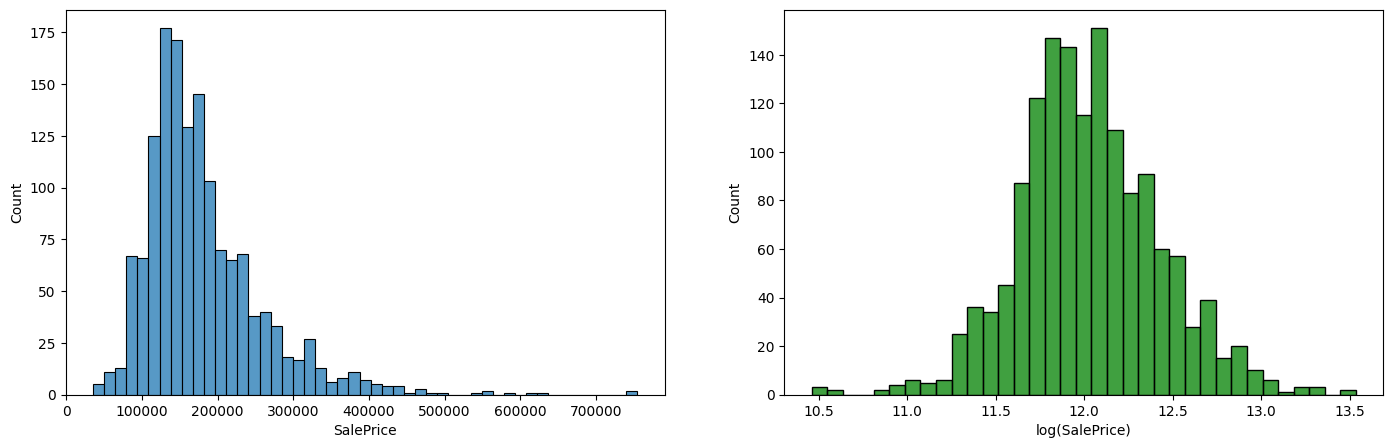

In [42]:
y_log = np.log(y)

plt.figure(figsize=(17, 5))

plt.subplot(1, 2, 1)
sns.histplot(y)

plt.subplot(1, 2, 2)
sns.histplot(y_log, color='green')

plt.xlabel("log(SalePrice)")

In [43]:
# Create your new scorer to minimize
rmse = make_scorer(lambda y_true, y_pred: mean_squared_error(y_true, y_pred)**0.5)

# Create your new scorer to maximize
rmse_neg = make_scorer(lambda y_true, y_pred: -1 * mean_squared_error(y_true, y_pred)**0.5)

## Add SVM estimator

In [35]:
# SOLUTION
allow_grid_searching = True # Use True to activate GridSearch in the notebook cells below

# Cache the preprocessing step of the pipeline
cachedir = mkdtemp()

In [39]:
model = SVR(kernel='linear')

pipe_svm = make_pipeline(preproc, model, memory=cachedir)
pipe_svm

Pipeline(memory='/tmp/tmpxtb_3i1w',
         steps=[('pipeline',
                 Pipeline(steps=[('columntransformer',
                                  ColumnTransformer(transformers=[('pipeline-1',
                                                                   Pipeline(steps=[('knnimputer',
                                                                                    KNNImputer()),
                                                                                   ('minmaxscaler',
                                                                                    MinMaxScaler())]),
                                                                   <sklearn.compose._column_transformer.make_column_selector object at 0x7f4a7b530790>),
                                                                  ('pipeline-2',
                                                                   Pipeline(steps=[('simpleimputer',
                                                                                    Simple...
                                                                    'Exterior2nd',
                                                                    'Foundation',
                                                                    'GarageType',
                                                                    'Heating',
                                                                    'HouseStyle',
                                                                    'LotConfig',
                                                                    'MSZoning',
                                                                    'MasVnrType',
                                                                    'MiscFeature',
                                                                    'Neighborhood',
                                                                    'RoofMatl',
                                                                    'RoofStyle',
                                                                    'SaleCondition',
                                                                    'SaleType',
                                                                    'Street',
                                                                    'Utilities'])])),
                                 ('selectpercentile',
                                  SelectPercentile(percentile=25,
                                                   score_func=<function mutual_info_regression at 0x7f4a7f72d1b0>))])),
                ('svr', SVR(kernel='linear'))])

In [ ]:
cross_val_score(pipe_svm, X, y_log, cv=5, scoring=rmse).mean()

In [47]:
# GridSearch
if allow_grid_searching:
    param_grid =  {
        'svr__C': [0.5, 0.7, 1, 2, 5, 10],
        'svr__epsilon': [0.01, 0.05, 0.1, 0.2, 0.5],
        #'svr__coef0': [0.0, 0.1, 0.5,1],
    }

    search_svm = GridSearchCV(
        pipe_svm,
        param_grid=param_grid,
        cv=5,
        n_jobs=-1,
        verbose=2,
        scoring=rmse_neg
    )

    search_svm.fit(X, y_log);

    svm_rbf_best = search_svm.best_estimator_

    print('\n----------------------------------------\n')
    print(f'Best params 👉 {search_svm.best_params_}')
    print(f'Best score 👉 {search_svm.best_score_}')

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[CV] END ......................svr__C=0.5, svr__epsilon=0.01; total time=   3.0s[CV] END ......................svr__C=0.5, svr__epsilon=0.01; total time=   3.0s

[CV] END ......................svr__C=0.5, svr__epsilon=0.01; total time=   3.0s


/home/pgducray/.pyenv/versions/lewagon/lib/python3.10/site-packages/sklearn/pipeline.py:370: UserWarning: Persisting input arguments took 0.50s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  X, fitted_transformer = fit_transform_one_cached(


[CV] END ......................svr__C=0.5, svr__epsilon=0.05; total time=   3.3s
[CV] END ......................svr__C=0.5, svr__epsilon=0.01; total time=   3.4s
[CV] END ......................svr__C=0.5, svr__epsilon=0.05; total time=   0.4s
[CV] END ......................svr__C=0.5, svr__epsilon=0.01; total time=   3.5s
[CV] END ......................svr__C=0.5, svr__epsilon=0.05; total time=   0.4s
[CV] END ......................svr__C=0.5, svr__epsilon=0.05; total time=   0.4s
[CV] END .......................svr__C=0.5, svr__epsilon=0.1; total time=   0.4s
[CV] END .......................svr__C=0.5, svr__epsilon=0.1; total time=   0.4s
[CV] END .......................svr__C=0.5, svr__epsilon=0.1; total time=   0.4s
[CV] END ......................svr__C=0.5, svr__epsilon=0.05; total time=   0.5s
[CV] END .......................svr__C=0.5, svr__epsilon=0.1; total time=   0.4s
[CV] END .......................svr__C=0.5, svr__epsilon=0.1; total time=   0.4s
[CV] END ...................

# Final Submission

Let discover our real score by submitting to Kaggle

In [48]:
X_test = pd.read_csv("https://wagon-public-datasets.s3.amazonaws.com/houses_test_raw.csv")

X_test_ids = X_test['Id'] # Keep ids
X_test = X_test.drop(columns=['Id'])

In [50]:
model = SVR(C =1, epsilon=0.05)
pipe_svm = make_pipeline(preproc, model, memory=cachedir)

pipe_svm.fit(X, y_log)

predictions_log = pipe_svm.predict(X_test)
predictions = np.exp(predictions_log)

In [51]:
results = pd.concat([X_test_ids, pd.Series(predictions, name="SalePrice")], axis=1)
results

,Id,SalePrice
0,1461,114043.202660
1,1462,162142.912735
2,1463,180774.542831
3,1464,194141.997045
4,1465,181343.598538
...,...,...
1454,2915,86402.446434
1455,2916,88839.515600
1456,2917,178767.259231
1457,2918,115786.096423


In [54]:
# Export to Kaggle format submission and submit it online!
import os

# Specify the folder path
folder_path = "data"  # Replace with the actual folder path you want

# Create the folder if it doesn't exist
if not os.path.exists(folder_path):
    os.makedirs(folder_path)

# Save the DataFrame to a CSV file in the specified folder
file_path = os.path.join(folder_path, "submission_ML_final.csv")
results.to_csv(file_path, header=True, index=False)

In [55]:
# Clear the cache directory at the end
rmtree(cachedir)

FileNotFoundError: [Errno 2] No such file or directory: '/tmp/tmpxtb_3i1w'